In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from hcipy import *
from scipy import ndimage
from scipy import fft

In [2]:
def retrieve_mode(holo,ref,x1=92,y1=265):
    fft_holo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(holo)))
    fft_ref = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(ref)))

    box_width = 131

    fftgram_filt = np.zeros(fft_holo.shape,dtype='complex128')
    fftgram_crop = fft_holo[int(x1-box_width/2):int(x1+box_width/2),int(y1-box_width/2):int(y1+box_width/2)]

    xmid = int(fftgram_filt.shape[0]/2)
    ymid = int(fftgram_filt.shape[1]/2)
    fftgram_filt[int(xmid-box_width/2):int(xmid+box_width/2),int(ymid-box_width/2):int(ymid+box_width/2)] = fftgram_crop
    filter_ft = np.zeros(fft_holo.shape)
    filter_ft[xmid,ymid]=1
    fftgram_filt = ndimage.gaussian_filter(filter_ft, 19)*fftgram_filt
    
    recon_map_large = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(fftgram_filt)))/np.sqrt(ref)
    recon_map_extent = 81
    recon_pad = recon_map_large.shape[0]-recon_map_extent
    recon_map = recon_map_large[int(recon_pad/2):int(-recon_pad/2+1),int(recon_pad/2):int(-recon_pad/2+1)]
    
    grid = make_uniform_grid([recon_map.shape[0],recon_map.shape[1]], [recon_map.shape[0],recon_map.shape[1]])
    recon_map_field = Field(np.transpose(recon_map).ravel(),grid)
    
    return recon_map_field



(60, 489, 489)


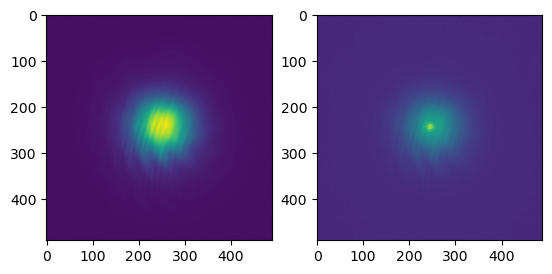

In [3]:
data_dir = "/home/vfndev/yxin/holography/ref_phase_test_230106/"

dark_flist = glob.glob(data_dir+"bkgd/*.fits")
dark_list = []
for file in dark_flist:
    dark_list.append(fits.getdata(file))
dark = np.mean(dark_list,axis=0)

ref_flist = glob.glob(data_dir+"reference/*.fits")
ref_list = []
for file in ref_flist:
    ref_list.append(fits.getdata(file))
ref = np.mean(ref_list,axis=0)-dark

holo_flist = glob.glob(data_dir+"timeseries/*.fits")
holo_list = []
timestamps = []
for file in holo_flist:
    holo_list.append(fits.getdata(file))
    timestamps.append(fits.getheader(file)['TIME'])
holos = np.array(holo_list)-dark
timestamps = np.array(timestamps)
timestamps = timestamps-np.min(timestamps)

centerx = 268
centery = 297
crop_width = 489

holos_crop = holos[:,int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]
ref_crop = ref[int(centerx-crop_width/2):int(centerx+crop_width/2),int(centery-crop_width/2):int(centery+crop_width/2)]

print(holos_crop.shape)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(ref_crop)
plt.subplot(1,2,2)
plt.imshow(holos_crop[0])


/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


14.25
3.0
0.040920619528122905


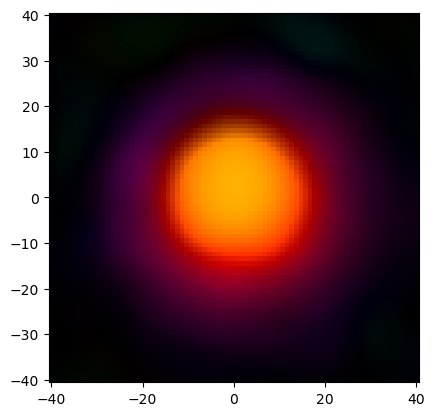

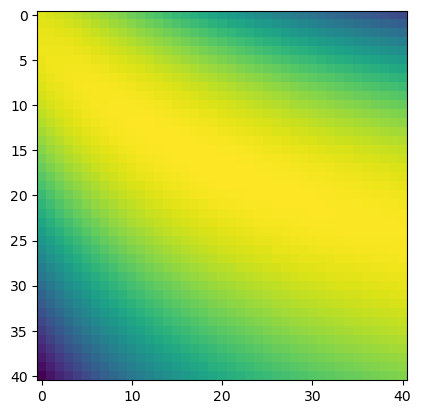

In [25]:
recon_map_field = retrieve_mode(holos_crop[0],ref_crop)
grid = recon_map_field.grid

#lp_modes = make_lp_modes(grid, V_nums[n], radii[m])

plt.figure()
imshow_field(recon_map_field,vmax=1e-3)

#decompose into LP modes
radii = np.linspace(10,20,41)
V_nums = np.linspace(2,4,41)
coeffs = np.zeros((len(radii),len(V_nums)))
for m in range(len(radii)):
    for n in range(len(V_nums)):
        lp_modes = make_lp_modes(grid, V_nums[n], radii[m])
        coeffs[m,n] = np.abs(np.nansum(np.conj(lp_modes[0])*recon_map_field,axis=None)/np.nansum(np.conj(lp_modes[0])*lp_modes[0],axis=None))
        
plt.figure()
plt.imshow(coeffs)

best_idx = np.unravel_index(np.argmax(coeffs),coeffs.shape)
best_r = radii[best_idx[0]]
best_Vnum = V_nums[best_idx[1]]

print(best_r)
print(best_Vnum)
print(coeffs[best_idx[0],best_idx[1]])

#plt.figure()
#plt.plot(radii,coeffs[:,0])
#plt.xlabel('Core rad (pix)')
#plt.ylabel('LP 01 Coeff')

#best_r_idx = np.argmax(coeffs[:,0])
#best_r = radii[best_r_idx]
#print(best_r)

lp_modes = make_lp_modes(grid, best_Vnum, best_r)


In [5]:
def optimize_shift_location(holo,ref,x1s,y1s):
    shift_coeffs = np.zeros((len(x1s),len(y1s)))
    for n in range(len(x1s)):
        for m in range(len(y1s)):
            recon_map_field = retrieve_mode(holo,ref,x1s[n],y1s[m])
            shift_coeffs[n,m] = np.abs(np.nansum(np.conj(lp_modes[0])*recon_map_field,axis=None)/np.nansum(np.conj(lp_modes[0])*lp_modes[0],axis=None))
            
    plt.figure()
    plt.imshow(shift_coeffs)
    idxs = np.unravel_index(np.argmax(shift_coeffs),shift_coeffs.shape)
    best_x = x1s[idxs[0]]
    best_y = y1s[idxs[1]]
    
    return best_x, best_y

/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


91.8
265.5


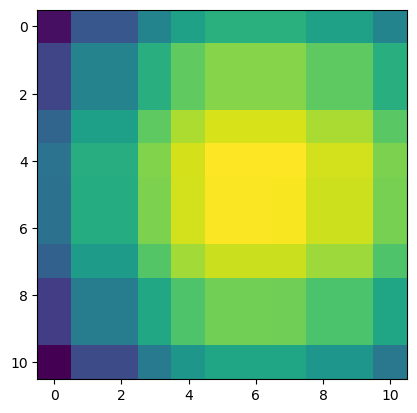

In [6]:
x1_0=92
y1_0=265

x1s = np.linspace(x1_0-3,x1_0+4,11)
y1s = np.linspace(y1_0-3,y1_0+4,11)

best_x, best_y = optimize_shift_location(holos_crop[0],ref_crop,x1s,y1s)
print(best_x)
print(best_y)

In [26]:
#extract timeseries data
coeffs_timeseries = []
orthog_timeseries = []
for holo_crop in holos_crop:
    recon_map_field = retrieve_mode(holo_crop,ref_crop,best_x,best_y)
    intensity = np.sum(np.square(np.abs(recon_map_field)))
    recon_map_field = recon_map_field/np.sqrt(intensity)
    coeffs_timeseries.append(np.nansum(np.conj(lp_modes[0])*recon_map_field,axis=None)/np.nansum(np.conj(lp_modes[0])*lp_modes[0],axis=None))
    orthog_timeseries.append(np.nansum(np.conj(lp_modes[1])*recon_map_field,axis=None)/np.nansum(np.conj(lp_modes[1])*lp_modes[1],axis=None))
coeffs_timeseries = np.array(coeffs_timeseries)
orthog_timeseries = np.array(orthog_timeseries)

/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/vfndev/anaconda3/envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


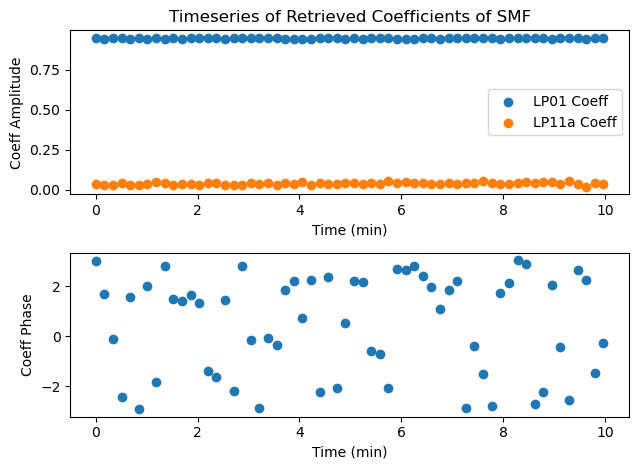

In [27]:
plt.figure()
plt.subplot(2,1,1)
plt.scatter(timestamps/60,np.abs(coeffs_timeseries),label = 'LP01 Coeff')
plt.scatter(timestamps/60,np.abs(orthog_timeseries),label = 'LP11a Coeff')
plt.xlabel('Time (min)')
plt.ylabel('Coeff Amplitude')
plt.legend()
plt.title('Timeseries of Retrieved Coefficients of SMF')
plt.subplot(2,1,2)
plt.scatter(timestamps/60,np.angle(coeffs_timeseries))
plt.xlabel('Time (min)')
plt.ylabel('Coeff Phase')
plt.tight_layout()
plt.savefig('ref_phase_test_230106/timeseries.png')

In [28]:
print(np.mean(np.abs(coeffs_timeseries)))

0.9459106988304423
